In [1]:
import sys
sys.path.append("../")

In [2]:
!pwd

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/azureuser/cloudfiles/code/users/p.peng/condmacroassetalloc/src/macroencoding


In [6]:
# load trained model
import torch.nn as nn
import torch
import numpy as np
import datetime as dt
import deepLearning
from deepLearning.dataloader import AssetClassReturn
from deepLearning.dataloader import MacroData
from torch.utils.data import DataLoader
import torch
import pandas as pd
import utils
import numpy as np
from typing import Any

TODAY = dt.datetime.today().strftime("%Y-%m-%d")
na_thresh = 500
macro_data = pd.read_pickle("../../data/macro/consolidated_macro_data.pkl")
macro_data = macro_data.dropna(thresh=na_thresh, axis=1).dropna(axis=0)
macro_data = macro_data.T.drop_duplicates().T
processor = utils.PreProcessor(macro_data, train_val_test_split=(0.67, 0.03, 0.30))

return_model = torch.load(f"../../checkpoints/returnmodel_2023-07-01_best_so_far.pt")

/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlp-gpu-t4/code/users/p.peng/condmacroassetalloc/src/macroencoding/utils/__init__.py:46: RuntimeWarning: divide by zero encountered in divide
  res[offset:] = np.log(input[offset:] / input[:-offset])
/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlp-gpu-t4/code/users/p.peng/condmacroassetalloc/src/macroencoding/utils/__init__.py:46: RuntimeWarning: divide by zero encountered in log
  res[offset:] = np.log(input[offset:] / input[:-offset])
/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlp-gpu-t4/code/users/p.peng/condmacroassetalloc/src/macroencoding/utils/__init__.py:46: RuntimeWarning: invalid value encountered in log
  res[offset:] = np.log(input[offset:] / input[:-offset])
/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlp-gpu-t4/code/users/p.peng/condmacroassetalloc/src/macroencoding/utils/__init__.py:46: RuntimeWarning: invalid value encountered in log
  res[offset:] = np.log(input[offset:] / input[:-offset])
/mnt/batch/tasks/sh

In [8]:
# load dataset
WINDOW_SIZE = 96
from deepLearning.dataloader import AssetClassReturn
from deepLearning.models.returnPrediction import ReturnPrediction

WINDOW_SIZE = 96
BATCH_SIZE = 128
return_model = ReturnPrediction(
    window_size=WINDOW_SIZE,
    autoencoder_ckpt_path=f"../../checkpoints/autoencoder_2023-07-01_best_so_far.pt",
    num_transformer_layers=5, 
    nhead=1, 
    # num_linear_layers=5,
    dim=7,
    ae_nhead=10,
    ae_dim=60,
    ae_num_transformer_layers=10,
    ae_encoding_dims=10)
return_model = return_model.eval()


asset_class_returns = pd.read_csv("../../data/asset_class_returns.csv", header=[0], index_col=[0])
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DTYPE = torch.float32

def collate_fn_return(input, device=DEVICE, dtype=DTYPE):
    """collate inputs batch first"""
    idxs, price_series, price_pad, return_series, macro_series, macro_paddings = [], [], [], [], [], []
    for idx, (price_sq, px_pd, ret, mac, mac_p) in enumerate(input):
        idxs.append(idx)
        price_series.append(price_sq)
        price_pad.append(px_pd)
        return_series.append(ret)
        macro_series.append(mac)
        macro_paddings.append(mac_p)
    return (
        idxs,
        torch.tensor(np.array(price_series), dtype=dtype).to(device),
        torch.tensor(np.array(price_pad), dtype=torch.bool).to(device),
        torch.tensor(np.array(return_series), dtype=torch.float).to(device),
        torch.tensor(macro_series, dtype=dtype).to(device),
        torch.tensor(macro_paddings, dtype=torch.bool).to(device)
    )

acr = AssetClassReturn(
    lookback_period=WINDOW_SIZE,
    lookahead_period=0,  # no need to look ahead when evaluating
    price_data=asset_class_returns.dropna(), 
    macro_data=macro_data,
    macro_window_size=WINDOW_SIZE,
    train_val_test_split=(0.515, 0.01, 0.475),
    dtype=torch.float32,
    mode="test",
    ignore_return=True)

acr_loader = DataLoader(acr, batch_size=2, shuffle=False, collate_fn=collate_fn_return)

ValueError: Invalid input, x is constant

In [9]:
return_model = return_model.eval()
default_starting_price = np.array([1.] * 7)
RNG = np.random.default_rng(seed=1234)


def _restore_difference_sequence(df: pd.DataFrame):
    df_ = df.apply(
        lambda row: row * acr._price_data_obj.var_ ** 0.5 + acr._price_data_obj.mean_, 
        axis=1)
    df_.loc[0, :] = 1.
    return df_


def _restore_price_sequence(
        df: pd.DataFrame, 
        cash_col: Any=6,
        starting_price: np.array=default_starting_price):
    last_period = starting_price
    df_ = df.copy(deep=True)
    rand_var = (RNG.random(size=len(df), ) - .5 ) / 1e10 # random
    for i, (indx, row ) in enumerate(df_.iterrows()):
        if i != 0:
            last_period *= (1 + row.values)
        df_.loc[indx] = last_period
    df_[cash_col] += rand_var # need cash_col to have slight variance to avoid inf
    return df_

def restore_price_sequence(acr_idx: int):
    df = pd.DataFrame(acr[acr_idx][0])
    df_ = _restore_difference_sequence(df)
    df_ = _restore_price_sequence(df_)
    return df_

In [10]:
restore_price_sequence(0)[0].plot()

NameError: name 'acr' is not defined

In [48]:
# black litterman allocation
from pypfopt import black_litterman, risk_models
from typing import Tuple

mcaps = [1/7] * 7 # equal weight by default

def get_cov_mat(idx):
    price_series = restore_price_sequence(idx)
    return price_series.corr()


def get_delta(idx: int, fillinf: float=1e1, fillna: float=1e-5) -> np.array:
    price_series = restore_price_sequence(idx)
    delta = black_litterman.market_implied_risk_aversion(price_series).replace(float("inf"), fillinf).replace(float("-inf"), fillinf).fillna(fillna)
    return delta

def get_prior(idx: int):
    price_series = restore_price_sequence(idx)
    delta = get_delta(idx)
    cov_mat = price_series.corr()
    prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_mat)
    return prior

def get_view(idx: int) -> np.array:
    price_series, _, macro_series, _ = acr[idx]
    price_series = torch.tensor(price_series, dtype=DTYPE).unsqueeze(0)
    macro_series = torch.tensor(macro_series, dtype=DTYPE).unsqueeze(0)
    # indx, price_series, price_padding, returns, macro_series, macro_padding = list(acr_loader)[idx]
    # return macro_series
    predictions = return_model(price_series, macro_series, None, None)
    return predictions

def get_weights(idx: int):
    predictions = get_view(idx)[0].detach().numpy()
    # view = dict(zip(asset_class_returns.columns, predictions))
    cov_mat = get_cov_mat(idx)
    prior = get_prior(idx)
    if prior.isna().sum() > 0:
        bl = black_litterman.BlackLittermanModel(
        cov_matrix=cov_mat, absolute_views=pd.Series(predictions))
    else:
        bl = black_litterman.BlackLittermanModel(
            cov_matrix=cov_mat, absolute_views=pd.Series(predictions), pi=prior)
    delta = get_delta(idx)
    bl.bl_weights(delta.values)
    weights = bl.clean_weights(cutoff=0.)
    weights = [v for _, v in weights.items()]
    weights = [v + (0- min(weights)) for v in weights]
    weights /= sum(weights)
    return weights
    

In [50]:
weights = []
for i in range(len(acr)):
    try:
        w = get_weights(i)
        weights.append(w)
    except Exception as e:
        print(e)
        weights.append(np.array([1.] + [0.] * 6)) # all SPX if no view 
        pass
        

Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix


/usr/local/anaconda3/envs/macroalloc_env/lib/python3.10/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")
/usr/local/anaconda3/envs/macroalloc_env/lib/python3.10/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")
/usr/local/anaconda3/envs/macroalloc_env/lib/python3.10/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")
/usr/local/anaconda3/envs/macroalloc_env/lib/python3.10/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")
/usr/local/anaconda3/envs/macroalloc_env/lib/python3.10/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior

In [51]:
restored_test_price = _restore_difference_sequence(acr.price_data_)
restored_test_price.iloc[0] = 1.

In [52]:
restored_price = _restore_price_sequence(restored_test_price, cash_col="Cash")

In [53]:
def cal_returns():
    worth = 100
    worths = []
    for idx, weight in enumerate(weights):
        worth_ = worth * weight
        worth_ = worth_ * restored_price.iloc[idx+WINDOW_SIZE] / restored_price.iloc[idx+WINDOW_SIZE -1]

        worth = sum(worth_)
        worths.append(worth)
    return worths, worth

In [54]:
restored_price /= restored_price.iloc[0]

In [55]:
worths, worth = cal_returns()

In [57]:
(restored_price.iloc[64-164] / restored_price.iloc[-164]).mean()

1.3859005003244553

In [58]:
[ret ** (12 / i) - 1 for i, ret in enumerate(worths) if i >=24]

[10.115569928694581,
 9.070420311381096,
 8.172975511816665,
 7.575765710594965,
 7.003894092528357,
 6.4774299541617735,
 5.985638327559904,
 5.400457858571337,
 5.102414997584426,
 4.833582313120996,
 4.565157765205085,
 4.331137348273589,
 4.051864870829527,
 3.8358358911796726,
 3.6324567279095588,
 3.4757891316329363,
 3.29405070654437,
 3.1553114670808347,
 2.998748820110603,
 2.847622195438679,
 2.7043396854826036,
 2.625714579826013,
 2.5324737439690352,
 2.4395828847575136,
 2.352593941769445,
 2.2712057277551865,
 2.206046562517782,
 2.1365706042222383,
 2.092121909070895,
 2.029826727864223,
 1.975968706913764,
 1.9027708084897617,
 1.8555219637093856,
 1.7916707678380162,
 1.7488084202736607,
 1.6825639714559122,
 1.6354003395105887,
 1.5930098403596542,
 1.5372790793338025,
 1.5004385511761145,
 1.4727738898065041,
 1.425637924767548,
 1.3965955479155023,
 1.3652465029011789,
 1.3337044252798735,
 1.2945575278839043,
 1.2632209951512512,
 1.2333232724566816,
 1.21774940468

In [59]:
pd.Series([ret ** (i/12) - 1 for i, ret in enumerate(worths) if i >=12]).std()

1.4829842483769404e+25

In [60]:
restored_price

,SPX,NASDAQComp,GOLD,Property,Commodities,CorpBonds,Cash
2001-10-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2001-11-30,1.072484,1.132974,0.981048,1.000000,1.007696,0.991513,1.0
2001-12-31,1.080577,1.144546,0.997182,1.006676,0.987647,0.984313,1.0
2002-01-31,1.063625,1.134899,1.009969,1.006676,0.980982,0.992630,1.0
2002-02-28,1.041296,1.009352,1.058811,1.006676,1.006079,0.999160,1.0
...,...,...,...,...,...,...,...
2023-02-28,2.896406,4.596646,4.859142,5.393219,1.150482,2.342806,1.0
2023-03-31,2.996191,4.894310,5.223755,5.294509,1.148110,2.407145,1.0
2023-04-28,3.039744,4.896180,5.278430,5.294509,1.139450,2.425503,1.0
2023-05-31,3.047281,5.172065,5.205597,5.294509,1.073346,2.390114,1.0


In [75]:
16.2 / 18.2

0.8901098901098901

In [72]:
1.163 ** 32

125.47317029019896

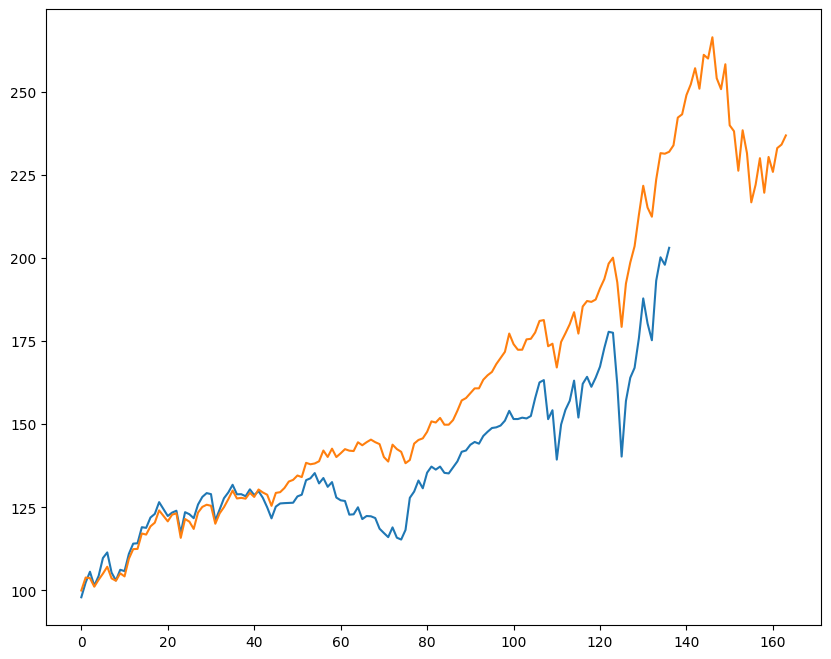

In [61]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(10, 8))
ax.plot(worths)
ax.plot((restored_price.iloc[-165:-1] / restored_price.iloc[-165]).mean(axis=1).values * 100)

In [77]:
np.log(6.591) / np.log(1.171)

11.945571787866905

In [78]:
1.163 ** 11.94

6.067667777234742

In [82]:
16.3 / 0.193

84.4559585492228